In [1]:
# Dependencies and Setup
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Data files
ride_data_orig = "Resources/Metro_Bike_Share_Trip_Data.csv"
ride_data_17_Q2 = "Resources/la_metro_gbfs_trips_Q2_2017.csv"
ride_data_17_Q3 = "Resources/metro-bike-share-trips-2017-q3.csv"
ride_data_17_Q4 = "Resources/metro-bike-share-trips-2017-q4-v2.csv"
ride_data_18_Q1 = "Resources/metro-bike-share-trips-2018-q1.csv"
#weather_data = "Resources/la_weather_2016_2018.csv" TBD

ride_orig_df = pd.read_csv(ride_data_orig, low_memory=False)
ride_17_Q2_df = pd.read_csv(ride_data_17_Q2, low_memory=False)
ride_17_Q3_df = pd.read_csv(ride_data_17_Q3, low_memory=False)
ride_17_Q4_df = pd.read_csv(ride_data_17_Q4, low_memory=False)
ride_18_Q1_df = pd.read_csv(ride_data_18_Q1, low_memory=False)

# This is for when the dataframes are combined for the rides per month for 2017 is created
ride_orig_df.rename(columns={'Start Time':'start_time'}, inplace=True)

# Drop columns that aren't needed (leaving some for future analysis)
# Note (Starting Lat-Long and Ending Lat-Long) do not exist in the newer data
ride_orig_df.drop(['Starting Station Latitude', 'Starting Station Longitude', 'Ending Station Latitude',
                   'Ending Station Longitude','Starting Lat-Long', 'Ending Lat-Long'], axis=1, inplace=True)
ride_17_Q2_df.drop(['start_lat', 'start_lon', 'end_lat', 'end_lon'], axis=1, inplace=True)
ride_17_Q3_df.drop(['start_lat', 'start_lon', 'end_lat', 'end_lon'], axis=1, inplace=True)
ride_17_Q4_df.drop(['start_lat', 'start_lon', 'end_lat', 'end_lon'], axis=1, inplace=True)
ride_18_Q1_df.drop(['start_lat', 'start_lon', 'end_lat', 'end_lon'], axis=1, inplace=True)

# Drop rows that have any NaN values
ride_orig_df = ride_orig_df.dropna()
ride_17_Q2_df = ride_17_Q2_df.dropna()
ride_17_Q3_df = ride_17_Q3_df.dropna()
ride_17_Q4_df = ride_17_Q4_df.dropna()
ride_18_Q1_df = ride_18_Q1_df.dropna()


In [2]:
# Datetime data after Q1 2017 is not zero padded and it has to be zero padded (see below)
def datetime_reformat(dt_str):
    # seperate date and time
    dt_strings = dt_str.split()
    date_str = dt_strings[0]
    time_str = dt_strings[1]
    
    # split up the date field
    date_fields = date_str.split("/")
    
    # do the formatting date
    if (len(date_str) == 6):
        # add zero to month and date
        new_date = "0" + date_fields[0] + "/0" + date_fields[1] + "/" + date_fields[2]
    elif (len(date_str) == 7):
        if (len(date_fields[0]) == 2):
            # add zero to day
            new_date = date_fields[0] + "/0" + date_fields[1] + "/" + date_fields[2]
        else:
            # add zero to month
            new_date = "0" + date_fields[0] + "/" + date_fields[1] + "/" + date_fields[2]
    else:
        new_date = date_str
    
    # do the formatting time
    if (len(time_str) == 4):
        # add zero to hour
        new_time = "0" + time_str
    else:
        new_time = time_str
        
    # final string
    new_str = new_date + " " + new_time
    
    return new_str


In [3]:
### Why datetime_reformat is needed ###

# start_time and end_time columns must be formated (zero padded) so they can be converted to python datetime obj.
# From https://stackoverflow.com/questions/41191365/python-datetime-strptime-error-is-a-bad-directive-in-format-m-d-y-h
# The use of %-m (for non-zero padded month value), will not work on a platform that dosn't have the
# proper GNU strftime C library function installed. Or from the Python datetime module documentation, the format
# codes that the C standard (1989 version) supports does not include %-m (and the others with a - indicating no
# zero padding). The 1999 version of the C standard added additional format codes. Interpreting these codes is not
# part of Python.
 
# Setup to use datetime_reformat function
v_format = np.vectorize(datetime_reformat)

# Convert to zero padded
ride_17_Q2_df['start_time'] = v_format(ride_17_Q2_df.start_time)
ride_17_Q2_df['end_time'] = v_format(ride_17_Q2_df.end_time)
ride_17_Q3_df['start_time'] = v_format(ride_17_Q3_df.start_time)
ride_17_Q3_df['end_time'] = v_format(ride_17_Q3_df.end_time)
ride_17_Q4_df['start_time'] = v_format(ride_17_Q4_df.start_time)
ride_17_Q4_df['end_time'] = v_format(ride_17_Q4_df.end_time)
ride_18_Q1_df['start_time'] = v_format(ride_18_Q1_df.start_time)
ride_18_Q1_df['end_time'] = v_format(ride_18_Q1_df.end_time)


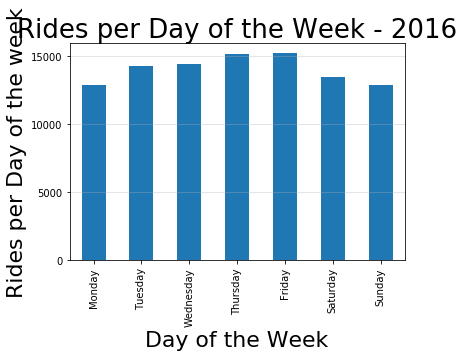

In [4]:
### This is the original csv file with data from 7/16 to 3/17 ###
### (But only using 2016 here, 2017 plotted later) ###

# Looking at total rides per day
# Convert date/time strings to datetime objects
ride_orig_df['start_time'] = pd.to_datetime(ride_orig_df['start_time'], format='%m/%d/%Y %I:%M:%S %p')

# Add Year column
ride_orig_df['Year'] = ride_orig_df['start_time'].dt.year

# 2016 data only
ride_orig_2016_df = ride_orig_df.loc[ride_orig_df['Year'] == 2016].copy()

# Get rid of unnessary columns
ride_trim_2016_df = ride_orig_2016_df[['start_time']].copy()

# Days of the week
ride_trim_2016_df['day_of_week'] = ride_trim_2016_df['start_time'].dt.weekday_name

# Group by days and count rides per day
weekday_counts_2016 = ride_trim_2016_df.groupby('day_of_week').count()

# Reindex so its Mon - Sun
weekday_counts_2016 = weekday_counts_2016.reindex(index = ['Monday', 'Tuesday', 'Wednesday', 'Thursday',
                                                           'Friday', 'Saturday', 'Sunday'])

# Create dataframe from grouped data
grouped_weekdays_2016_df = pd.DataFrame(weekday_counts_2016)

grouped_weekdays_2016_df.plot(kind='bar', legend=False)

plt.grid(axis='y', alpha=0.4)
plt.xlabel("Day of the Week", fontsize = 22)
plt.ylabel("Rides per Day of the week", fontsize = 22)
plt.title('Rides per Day of the Week - 2016', fontsize = 26)

plt.rcParams['figure.figsize'] = (20,12)

plt.rc('xtick',labelsize=20)
plt.rc('ytick',labelsize=20)



In [5]:
# Show plot
plt.show()

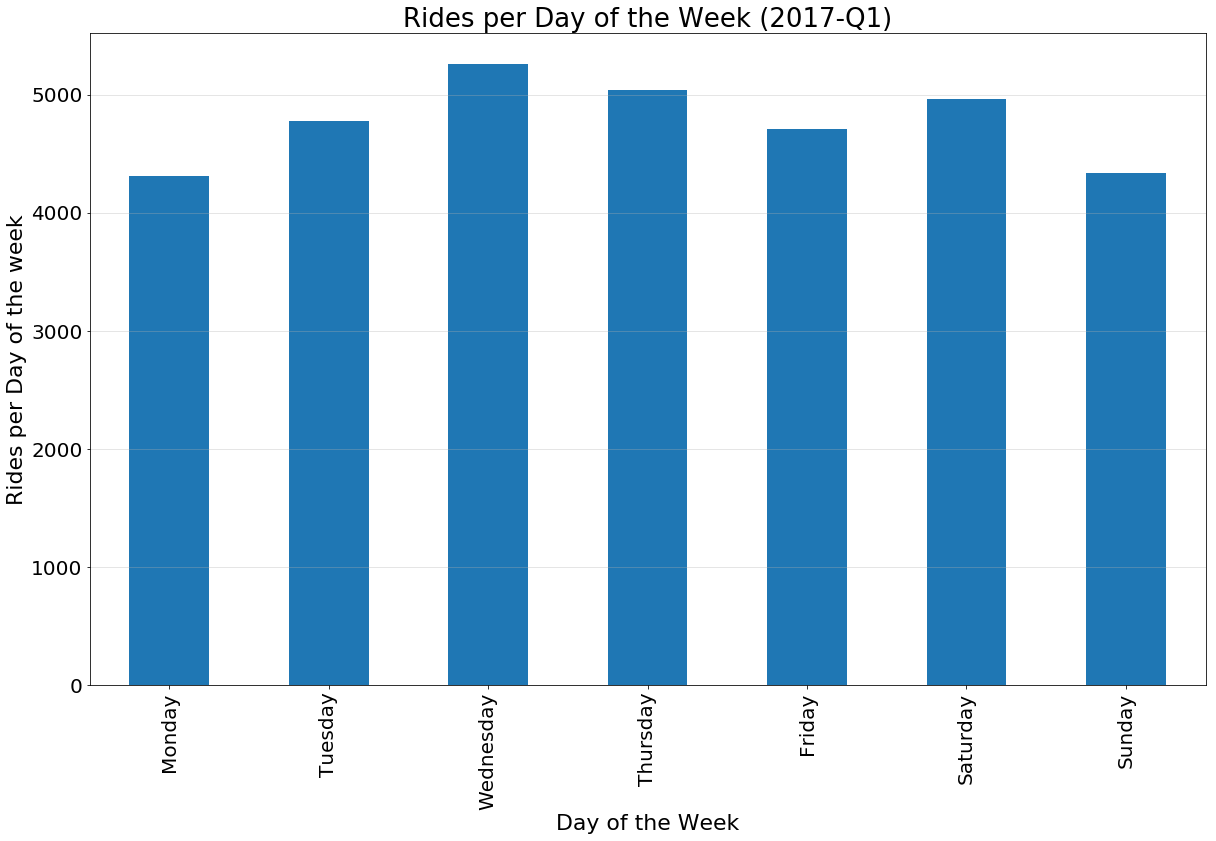

In [6]:
######## QUARTER 1 2017 ########
######## RIDES PER DAY OF THE WEEK ########

# Looking at total rides per day
# Convert date/time strings to datetime objects
ride_orig_df['start_time'] = pd.to_datetime(ride_orig_df['start_time'], format='%m/%d/%Y %I:%M:%S %p')

# Add Year column
ride_orig_df['Year'] = ride_orig_df['start_time'].dt.year

# 2017 data only
ride_orig_17_Q1_df = ride_orig_df.loc[ride_orig_df['Year'] == 2017].copy()

# Get rid of unnessary columns
ride_trim_17_Q1_df = ride_orig_17_Q1_df[['start_time']].copy()

# Days of the week
ride_trim_17_Q1_df['day_of_week'] = ride_trim_17_Q1_df['start_time'].dt.weekday_name

# Group by days and count rides per day
weekday_counts_17_Q1 = ride_trim_17_Q1_df.groupby('day_of_week').count()

# Reindex so its Mon - Sun
weekday_counts_17_Q1 = weekday_counts_17_Q1.reindex(index = ['Monday', 'Tuesday', 'Wednesday', 'Thursday',
                                                           'Friday', 'Saturday', 'Sunday'])

# Create dataframe from grouped data
grouped_weekdays_17_Q1_df = pd.DataFrame(weekday_counts_17_Q1)

grouped_weekdays_17_Q1_df.plot(kind='bar', legend=False)

plt.grid(axis='y', alpha=0.4)
plt.xlabel("Day of the Week", fontsize = 22)
plt.ylabel("Rides per Day of the week", fontsize = 22)
plt.title('Rides per Day of the Week (2017-Q1)', fontsize = 26)

plt.rcParams['figure.figsize'] = (20,12)

plt.rc('xtick',labelsize=20)
plt.rc('ytick',labelsize=20)


In [7]:
# Show plot
plt.show()

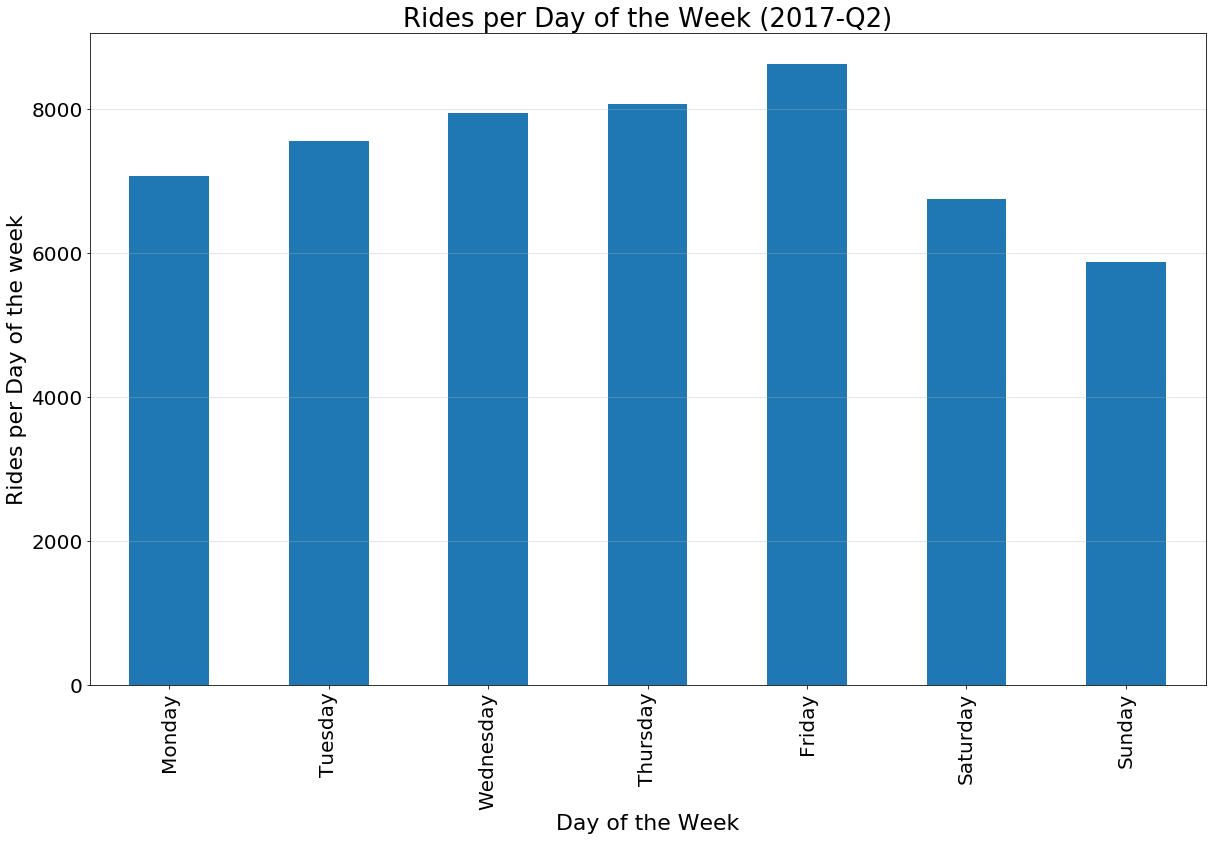

In [8]:
######## QUARTER 2 2017 ########
######## RIDES PER DAY OF THE WEEK ########

# Looking at total rides per day
# Convert date/time strings to datetime objects
ride_17_Q2_df['start_time'] = pd.to_datetime(ride_17_Q2_df['start_time'], format='%m/%d/%y %H:%M')

# Add Year column
ride_17_Q2_df['Year'] = ride_17_Q2_df['start_time'].dt.year

# Get rid of unnessary columns
ride_trim_17_Q2_df = ride_17_Q2_df[['start_time']].copy()

# Days of the week
ride_trim_17_Q2_df['day_of_week'] = ride_trim_17_Q2_df['start_time'].dt.weekday_name

# Group by days and count rides per day
weekday_counts_17_Q2 = ride_trim_17_Q2_df.groupby('day_of_week').count()

# Reindex so its Mon - Sun
weekday_counts_17_Q2 = weekday_counts_17_Q2.reindex(index = ['Monday', 'Tuesday', 'Wednesday', 'Thursday',
                                                           'Friday', 'Saturday', 'Sunday'])

# Create dataframe from grouped data
grouped_weekdays_17_Q2_df = pd.DataFrame(weekday_counts_17_Q2)

grouped_weekdays_17_Q2_df.plot(kind='bar', legend=False)

plt.grid(axis='y', alpha=0.4)
plt.xlabel("Day of the Week", fontsize = 22)
plt.ylabel("Rides per Day of the week", fontsize = 22)
plt.title('Rides per Day of the Week (2017-Q2)', fontsize = 26)

plt.rcParams['figure.figsize'] = (20,12)

plt.rc('xtick',labelsize=20)
plt.rc('ytick',labelsize=20)


In [9]:
# Show plot
plt.show()

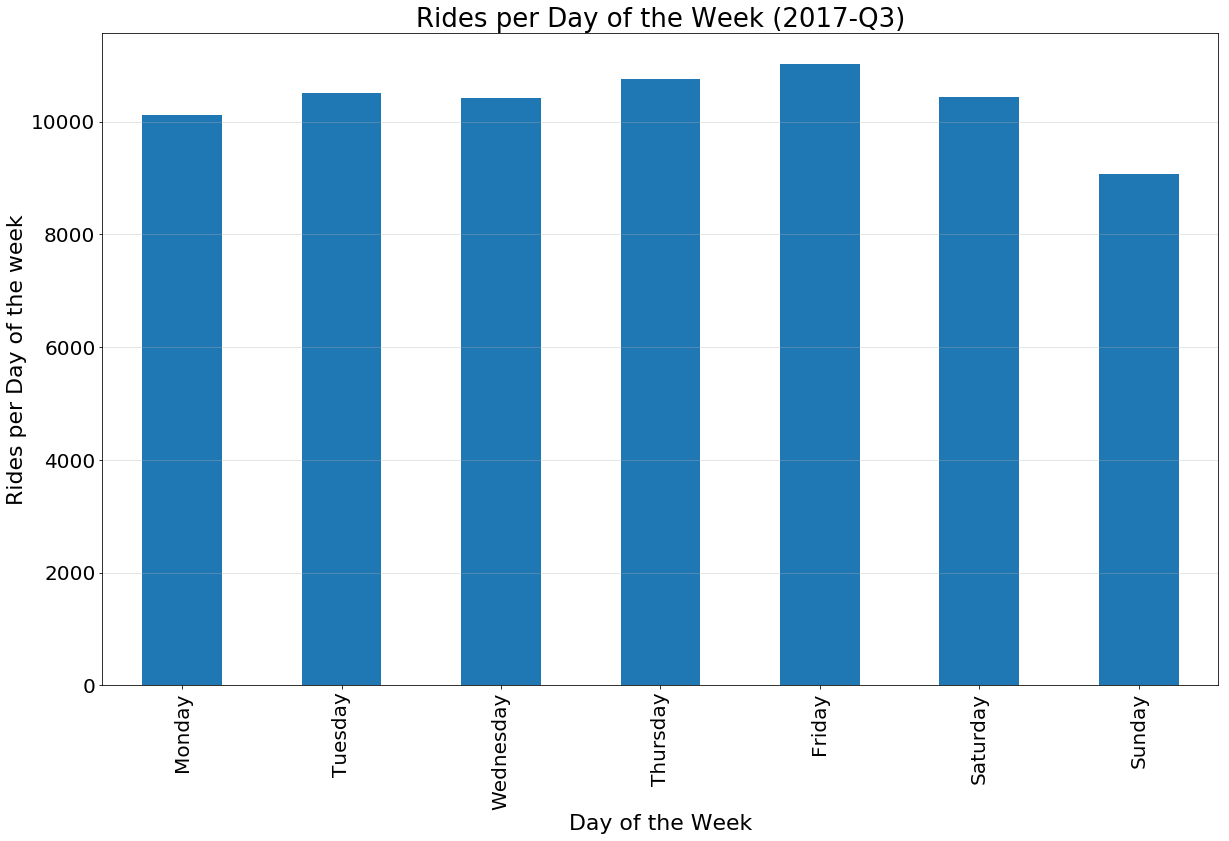

In [10]:
######## QUARTER 3 2017 ########
######## RIDES PER DAY OF THE WEEK ########

# Looking at total rides per day
# Convert date/time strings to datetime objects
ride_17_Q3_df['start_time'] = pd.to_datetime(ride_17_Q3_df['start_time'], format='%m/%d/%y %H:%M')

# Add Year column
ride_17_Q3_df['Year'] = ride_17_Q3_df['start_time'].dt.year

# Get rid of unnessary columns
ride_trim_17_Q3_df = ride_17_Q3_df[['start_time']].copy()

# Days of the week
ride_trim_17_Q3_df['day_of_week'] = ride_trim_17_Q3_df['start_time'].dt.weekday_name

# Group by days and count rides per day
weekday_counts_17_Q3 = ride_trim_17_Q3_df.groupby('day_of_week').count()

# Reindex so its Mon - Sun
weekday_counts_17_Q3 = weekday_counts_17_Q3.reindex(index = ['Monday', 'Tuesday', 'Wednesday', 'Thursday',
                                                           'Friday', 'Saturday', 'Sunday'])

# Create dataframe from grouped data
grouped_weekdays_17_Q3_df = pd.DataFrame(weekday_counts_17_Q3)

grouped_weekdays_17_Q3_df.plot(kind='bar', legend=False)

plt.grid(axis='y', alpha=0.4)
plt.xlabel("Day of the Week", fontsize = 22)
plt.ylabel("Rides per Day of the week", fontsize = 22)
plt.title('Rides per Day of the Week (2017-Q3)', fontsize = 26)

plt.rcParams['figure.figsize'] = (20,12)

plt.rc('xtick',labelsize=20)
plt.rc('ytick',labelsize=20)


In [11]:
# Show plot
plt.show()

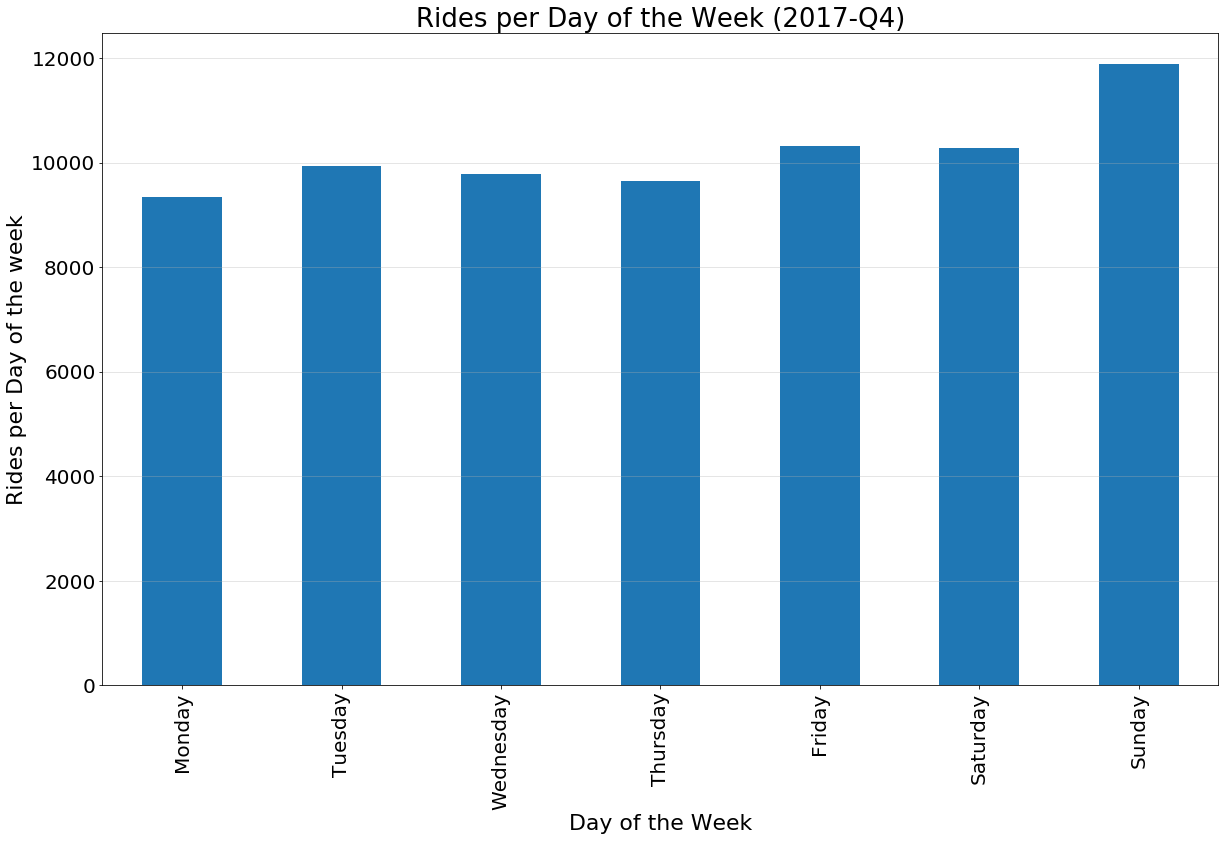

In [12]:
######## QUARTER 4 2017 ########
######## RIDES PER DAY OF THE WEEK ########

# Looking at total rides per day
# Convert date/time strings to datetime objects
ride_17_Q4_df['start_time'] = pd.to_datetime(ride_17_Q4_df['start_time'], format='%m/%d/%y %H:%M')

# Add Year column
ride_17_Q4_df['Year'] = ride_17_Q4_df['start_time'].dt.year

# Get rid of unnessary columns
ride_trim_17_Q4_df = ride_17_Q4_df[['start_time']].copy()

# Days of the week
ride_trim_17_Q4_df['day_of_week'] = ride_trim_17_Q4_df['start_time'].dt.weekday_name

# Group by days and count rides per day
weekday_counts_17_Q4 = ride_trim_17_Q4_df.groupby('day_of_week').count()

# Reindex so its Mon - Sun
weekday_counts_17_Q4 = weekday_counts_17_Q4.reindex(index = ['Monday', 'Tuesday', 'Wednesday', 'Thursday',
                                                           'Friday', 'Saturday', 'Sunday'])

# Create dataframe from grouped data
grouped_weekdays_17_Q4_df = pd.DataFrame(weekday_counts_17_Q4)

grouped_weekdays_17_Q4_df.plot(kind='bar', legend=False)

plt.grid(axis='y', alpha=0.4)
plt.xlabel("Day of the Week", fontsize = 22)
plt.ylabel("Rides per Day of the week", fontsize = 22)
plt.title('Rides per Day of the Week (2017-Q4)', fontsize = 26)

plt.rcParams['figure.figsize'] = (20,12)

plt.rc('xtick',labelsize=20)
plt.rc('ytick',labelsize=20)



In [13]:
# Show plot
plt.show()

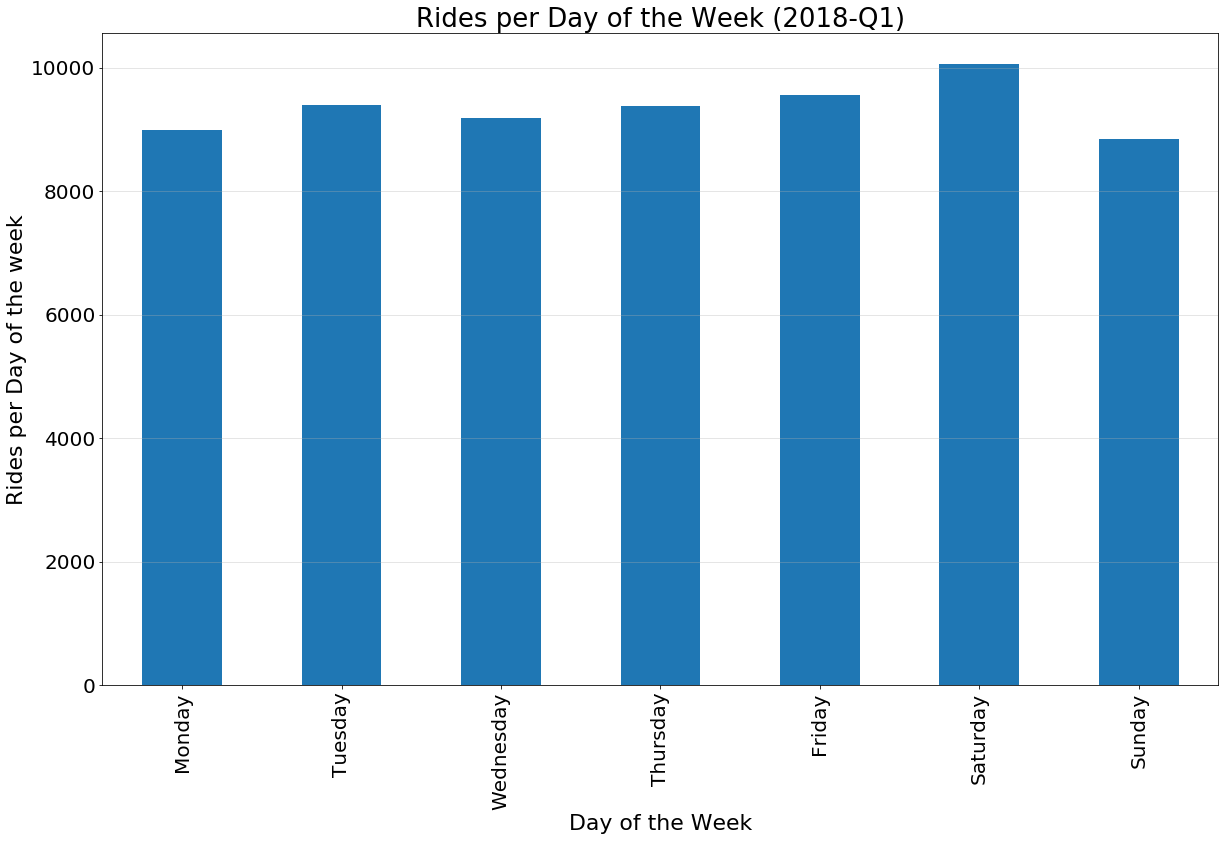

In [14]:
######## QUARTER 1 2018 ########
######## RIDES PER DAY OF THE WEEK ########

# Looking at total rides per day
# Convert date/time strings to datetime objects
ride_18_Q1_df['start_time'] = pd.to_datetime(ride_18_Q1_df['start_time'], format='%m/%d/%y %H:%M')

# Add Year column
ride_18_Q1_df['Year'] = ride_18_Q1_df['start_time'].dt.year

# Get rid of unnessary columns
ride_trim_18_Q1_df = ride_18_Q1_df[['start_time']].copy()

# Days of the week
ride_trim_18_Q1_df['day_of_week'] = ride_trim_18_Q1_df['start_time'].dt.weekday_name

# Group by days and count rides per day
weekday_counts_18_Q1 = ride_trim_18_Q1_df.groupby('day_of_week').count()

# Reindex so its Mon - Sun
weekday_counts_18_Q1 = weekday_counts_18_Q1.reindex(index = ['Monday', 'Tuesday', 'Wednesday', 'Thursday',
                                                           'Friday', 'Saturday', 'Sunday'])

# Create dataframe from grouped data
grouped_weekdays_18_Q1_df = pd.DataFrame(weekday_counts_18_Q1)

grouped_weekdays_18_Q1_df.plot(kind='bar', legend=False)

plt.grid(axis='y', alpha=0.4)
plt.xlabel("Day of the Week", fontsize = 22)
plt.ylabel("Rides per Day of the week", fontsize = 22)
plt.title('Rides per Day of the Week (2018-Q1)', fontsize = 26)

plt.rcParams['figure.figsize'] = (20,12)

plt.rc('xtick',labelsize=20)
plt.rc('ytick',labelsize=20)


In [15]:
# Show plot
plt.show()

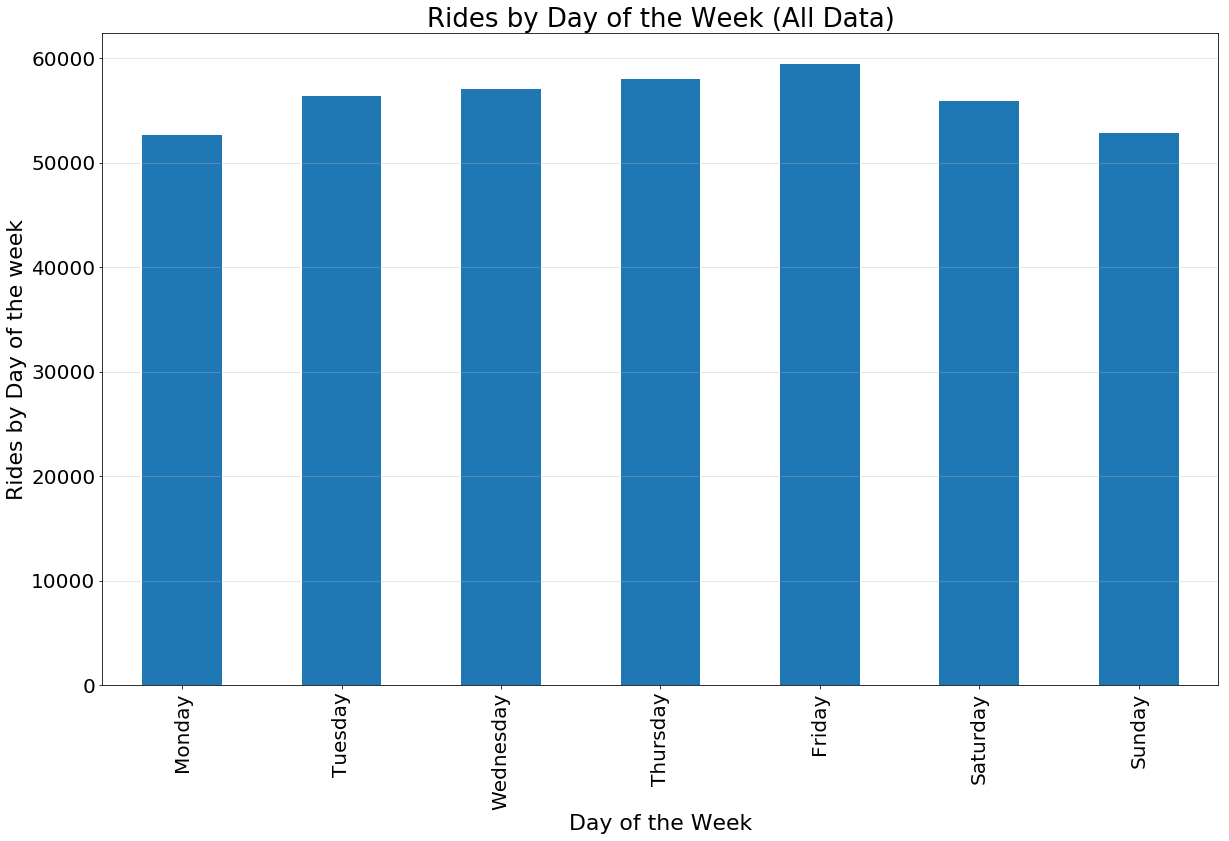

In [16]:
######## ALL DATA ########
######## RIDES PER DAY OF THE WEEK ########

# Using data from previous plots
# Create one dataframe
frames = [ride_trim_2016_df, ride_trim_17_Q1_df, ride_trim_17_Q2_df, ride_trim_17_Q3_df,
          ride_trim_17_Q4_df, ride_trim_18_Q1_df]
combined_all_rides_df = pd.concat(frames, ignore_index=True)

# Group by days and count rides per day
weekday_counts_all = combined_all_rides_df.groupby('day_of_week').count()

# Reindex so its Mon - Sun
weekday_counts_all = weekday_counts_all.reindex(index = ['Monday', 'Tuesday', 'Wednesday', 'Thursday',
                                                         'Friday', 'Saturday', 'Sunday'])
# Create dataframe from grouped data
grouped_weekdays_all_df = pd.DataFrame(weekday_counts_all)

grouped_weekdays_all_df.plot(kind='bar', legend=False)

plt.grid(axis='y', alpha=0.4)
plt.xlabel("Day of the Week", fontsize = 22)
plt.ylabel("Rides by Day of the week", fontsize = 22)
plt.title('Rides by Day of the Week (All Data)', fontsize = 26)

plt.rcParams['figure.figsize'] = (20,12)

plt.rc('xtick',labelsize=20)
plt.rc('ytick',labelsize=20)


In [17]:
# Show plot
plt.show()

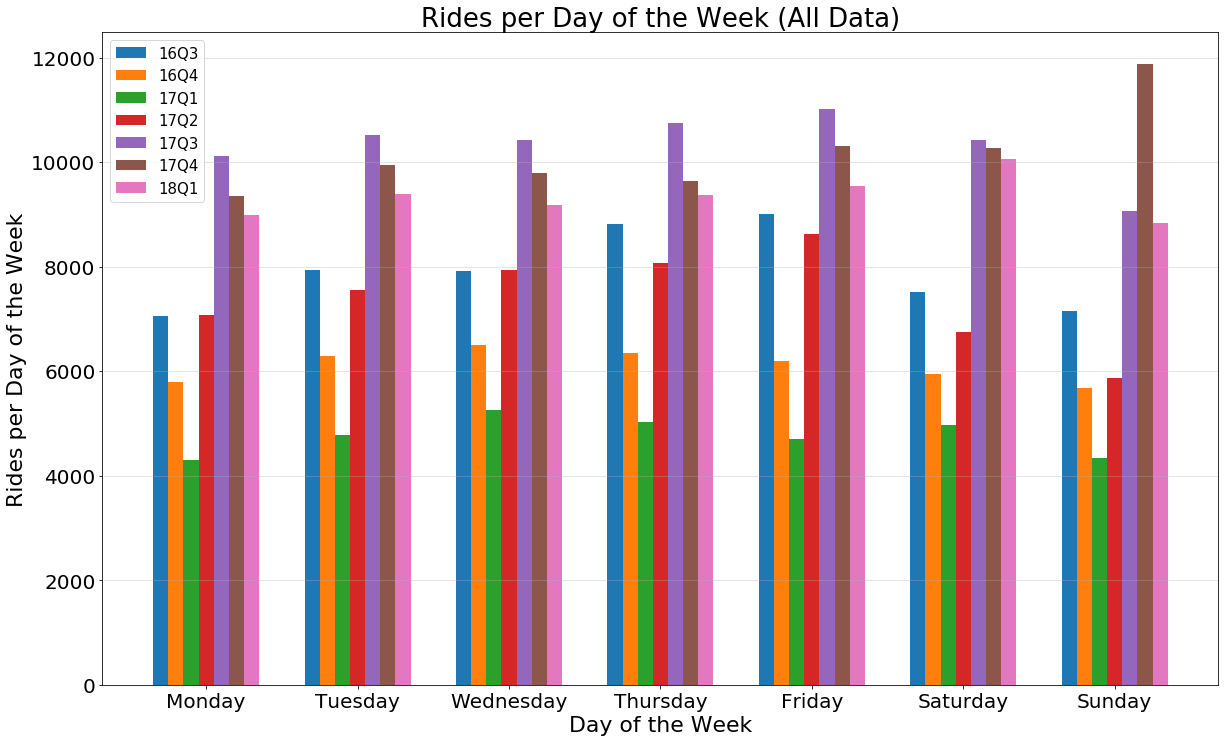

In [18]:
### All in One
### All quarters side by side

# Pull out Q3 and Q4 from original data
# Original data 2016 only (Jun to Dec
# Add Month column
ride_orig_2016_df['month'] = ride_orig_2016_df['start_time'].dt.month

# Pull out the months
ride_orig_2016_Q3_7_df = ride_orig_2016_df.loc[ride_orig_2016_df['month'] == 7].copy()
ride_orig_2016_Q3_8_df = ride_orig_2016_df.loc[ride_orig_2016_df['month'] == 8].copy()
ride_orig_2016_Q3_9_df = ride_orig_2016_df.loc[ride_orig_2016_df['month'] == 9].copy()
ride_orig_2016_Q4_10_df = ride_orig_2016_df.loc[ride_orig_2016_df['month'] == 10].copy()
ride_orig_2016_Q4_11_df = ride_orig_2016_df.loc[ride_orig_2016_df['month'] == 11].copy()
ride_orig_2016_Q4_12_df = ride_orig_2016_df.loc[ride_orig_2016_df['month'] == 12].copy()

# Make the quarter dataframes for 2016
framesQ3 = [ride_orig_2016_Q3_7_df, ride_orig_2016_Q3_8_df, ride_orig_2016_Q3_9_df]
ride_orig_16_Q3_df = pd.concat(framesQ3, ignore_index=True)
framesQ4 = [ride_orig_2016_Q4_10_df, ride_orig_2016_Q4_11_df, ride_orig_2016_Q4_12_df]
ride_orig_16_Q4_df = pd.concat(framesQ4, ignore_index=True)

# Get rid of unnessary columns
ride_trim_16_Q3_df = ride_orig_16_Q3_df[['start_time']].copy()
ride_trim_16_Q4_df = ride_orig_16_Q4_df[['start_time']].copy()

# Days of the week
ride_trim_16_Q3_df['day_of_week'] = ride_trim_16_Q3_df['start_time'].dt.weekday_name
ride_trim_16_Q4_df['day_of_week'] = ride_trim_16_Q4_df['start_time'].dt.weekday_name

# Group by days and count rides per day
weekday_counts_16_Q3 = ride_trim_16_Q3_df.groupby('day_of_week').count()
weekday_counts_16_Q4 = ride_trim_16_Q4_df.groupby('day_of_week').count()

# Reindex so its Mon - Sun
weekday_counts_16_Q3 = weekday_counts_16_Q3.reindex(index = ['Monday', 'Tuesday', 'Wednesday', 'Thursday',
                                                           'Friday', 'Saturday', 'Sunday'])
weekday_counts_16_Q4 = weekday_counts_16_Q4.reindex(index = ['Monday', 'Tuesday', 'Wednesday', 'Thursday',
                                                           'Friday', 'Saturday', 'Sunday'])

# Create dataframe from grouped data
grouped_weekdays_16_Q3_df = pd.DataFrame(weekday_counts_16_Q3)
grouped_weekdays_16_Q4_df = pd.DataFrame(weekday_counts_16_Q4)


# Build the plot
# start_time has the count per day of the week
y_axis_16Q3 = grouped_weekdays_16_Q3_df['start_time']
y_axis_16Q4 = grouped_weekdays_16_Q4_df['start_time']
y_axis_17Q1 = grouped_weekdays_17_Q1_df['start_time']
y_axis_17Q2 = grouped_weekdays_17_Q2_df['start_time']
y_axis_17Q3 = grouped_weekdays_17_Q3_df['start_time']
y_axis_17Q4 = grouped_weekdays_17_Q4_df['start_time']
y_axis_18Q1 = grouped_weekdays_18_Q1_df['start_time']

x_axis = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
_x_axis = np.arange(len(x_axis))

plt.bar(_x_axis - 0.3, y_axis_16Q3, width=0.1, label="16Q3")
plt.bar(_x_axis - 0.2, y_axis_16Q4, width=0.1, label="16Q4")
plt.bar(_x_axis - 0.1, y_axis_17Q1, width=0.1, label="17Q1")
plt.bar(_x_axis - 0.0, y_axis_17Q2, width=0.1, label="17Q2")
plt.bar(_x_axis + 0.1, y_axis_17Q3, width=0.1, label="17Q3")
plt.bar(_x_axis + 0.2, y_axis_17Q4, width=0.1, label="17Q4")
plt.bar(_x_axis + 0.3, y_axis_18Q1, width=0.1, label="18Q1")
plt.xticks(_x_axis, x_axis) # set labels manually

plt.legend(loc='upper left', fontsize = 15)

plt.grid(axis='y', alpha=0.4)
plt.xlabel("Day of the Week", fontsize = 22)
plt.ylabel("Rides per Day of the Week", fontsize = 22)
plt.title('Rides per Day of the Week (All Data)', fontsize = 26)

plt.rcParams['figure.figsize'] = (20,12)

plt.rc('xtick',labelsize=20)
plt.rc('ytick',labelsize=20)


In [19]:
# Show plot
plt.show()